In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def get_stats(S):
    max_ = S.max()
    min_ = S.min()
    std_ = S.std()
    avg_ = S.mean()
    return max_, min_, std_, avg_

def get_features(df):
    max_avP, min_avP, std_avP, avg_avP = get_stats(df.avP)
    max_dP, min_dP, std_dP, avg_dP = get_stats(df.dP)
    max_avI, min_avI, std_avI, avg_avI = get_stats(df.avI)
    max_dI, min_dI, std_dI, avg_dI = get_stats(df.dI)
    max_f1, min_f1, std_f1, avg_f1 = get_stats(df.f1)
    max_dF1, min_dF1, std_dF1, avg_dF1 = get_stats(df.dF1)
    max_f2, min_f2, std_f2, avg_f2 = get_stats(df.f2)
    max_dF2, min_dF2, std_dF2, avg_dF2 = get_stats(df.dF2)
    max_h, min_h, std_h, avg_h = get_stats(df.h)
    return dict(id = df.id[0],
        max_avP = max_avP, min_avP = min_avP, std_avP = std_avP, avg_avP = avg_avP,
        max_dP = max_dP, min_dP = min_dP, std_dP = std_dP, avg_dP = avg_dP,
        max_avI = max_avI, min_avI = min_avI, std_avI = std_avI, avg_avI = avg_avI,
        max_dI = max_dI, min_dI = min_dI, std_dI = std_dI, avg_dI = avg_dI,
        max_f1 = max_f1, min_f1 = min_f1, std_f1 = std_f1, avg_f1 = avg_f1,
        max_dF1 = max_dF1, min_dF1 = min_dF1, std_dF1 = std_dF1, avg_dF1 = avg_dF1,
        max_f2 = max_f2, min_f2 = min_f2, std_f2 = std_f2, avg_f2 = avg_f2,
        max_dF2 = max_dF2, min_dF2 = min_dF2, std_dF2 = std_dF2, avg_dF2 = avg_dF2,
        max_h = max_h, min_h = min_h, std_h = std_h, avg_h = avg_h)

def preprocess_audio(directory):
    all_files = os.listdir(directory)
    data = []

    for file in all_files:
        filename = directory + file
        df = pd.read_csv(filename, sep = '\t')
        df['id'] = filename[16:-4]
        features = get_features(df)
        data.append(features)

    data = pd.DataFrame.from_dict(data)
    cols = data.columns.tolist()
    cols.remove('id')
    cols = ['id'] + cols
    data = data[cols]
    return data

In [3]:
def preprocess_scores(directory):
    all_files = os.listdir(directory)
    scores_dfs = []
    for file in all_files:
        filename = directory + file
        scores = pd.read_csv(filename)
        scores.columns = ['id', 'Ext', 'Agr', 'Con', 'Neur', 'Open']
        ext_avg = scores.Ext.mean()
        agr_avg = scores.Agr.mean()
        con_avg = scores.Con.mean()
        neur_avg = scores.Neur.mean()
        open_avg = scores.Open.mean()
        averages = (ext_avg, agr_avg, con_avg, neur_avg, open_avg)
        def classify(row, averages = averages):
            def get_class(score,avg):
                if score > avg: return 1
                else: return 0

            ext_avg, agr_avg, con_avg, neur_avg, open_avg = averages
            class_ext = get_class(row.Ext, ext_avg)
            class_agr = get_class(row.Agr, agr_avg)
            class_con = get_class(row.Con, con_avg)
            class_neur = get_class(row.Neur, neur_avg)
            class_open = get_class(row.Open, open_avg)
            return (class_ext, class_agr, class_con, class_neur, class_open)

        scores['Ext'], scores["Agr"], scores["Con"], scores["Neur"], scores["Open"] = zip(*scores.apply(classify,axis=1))
        scores_dfs.append(scores)
    ids = scores_dfs[0].id
    scores = scores_dfs[0].drop('id',axis=1)
    for i in range(1,len(scores_dfs)):
        scores = scores.add(scores_dfs[i].drop('id',axis=1))
    scores['id'] = ids
    return scores

In [4]:
data = preprocess_audio('../output/')
scores = preprocess_scores('Personality_Scores/')
df = data.merge(scores, on='id', how='left')

In [5]:
def mkdata(df, trait_name, threshold = 1):
    traits = ['Ext', 'Agr', 'Con', 'Neur', 'Open']
    traits.remove(trait_name)
    data = df.drop(traits, axis=1)
    data = data.drop(['id'], axis=1)
    def labelify(row):
        if row[trait_name] > 6 + threshold: return 1
        elif row[trait_name] < 6 - threshold: return 0
        else: return -1
    data[trait_name] = data.apply(labelify, axis = 1)
    data = data[data[trait_name] >= 0]
    data = data.rename(columns = {trait_name: 'label'})
    return data

In [10]:
data = mkdata(df, 'Con', 0)
def get_score(data, get_features = 0):
    X_train, X_test, y_train, y_test = train_test_split(data.drop('label', axis = 1), data.label, test_size=0.20, random_state=42)

    model = AdaBoostClassifier()
    model.fit(X_train, y_train)
    if get_features:
        return model.feature_importances

    return model.score(X_test, y_test)

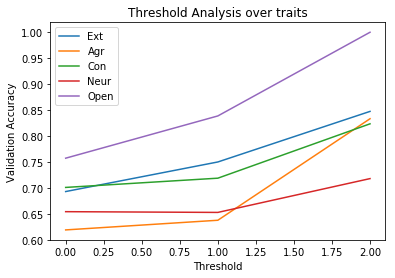

In [11]:
#Threshold analysis
traits = ['Ext', 'Agr', 'Con', 'Neur', 'Open']
for label in traits:
    threshold_scores = []
    for i in range(0,3):
        data = mkdata(df,label,i)
        threshold_scores.append(get_score(data))
    plt.plot(threshold_scores)
plt.title('Threshold Analysis over traits')
plt.legend(traits)
plt.ylabel('Validation Accuracy')
plt.xlabel('Threshold')
plt.show()

In [137]:
#Model accuracy
threshold = 1
traits = ['Ext', 'Agr', 'Con', 'Neur', 'Open']
scores = []

for label in traits:
    data = mkdata(df,label,threshold)
    #data=data.drop(['avg_h','min_h','max_h','std_h'],axis=1)
    scores.append(get_score(data))
for i, score in enumerate(scores):
    print(traits[i], score)

Ext 0.75
Agr 0.6376811594202898
Con 0.71875
Neur 0.6527777777777778
Open 0.8387096774193549


Text(0,0.5,'coefficient')

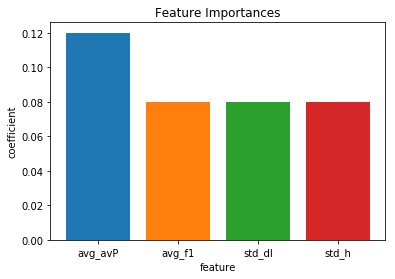

In [16]:
#Feature importances
data = mkdata(df,'Ext',1)
#data=data.drop(['avg_h','min_h','max_h','std_h'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(data.drop('label', axis = 1), data.label, test_size=0.20, random_state=42)

model = AdaBoostClassifier()
model.fit(X_train, y_train)
importances = model.feature_importances_
features = list(X_train)
for i, importance in enumerate(importances):
    #print(features[i], importance)
    if importance > 0.06:
        plt.bar(features[i],importance)
        
plt.title("Feature Importances")
plt.xlabel("feature")
plt.ylabel('coefficient')

TypeError: <lambda>() missing 1 required positional argument: 'height'

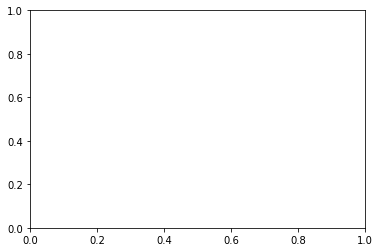